In [81]:
import wandb
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import importlib
from common import common
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.datasets import fetch_covtype

In [82]:
wandb.login()

True

In [83]:
# Reload common module
importlib.reload(common)

<module 'common.common' from '/Users/bytedance/Downloads/work/CS5344_Project/work/common/common.py'>

In [84]:
# Function to evaluate and print model performance
def evaluate_model(model, X_train, y_train, X_test, y_test):
    seconds = time.time()
    # Train the model
    model.fit(X_train, y_train)
    print("Train operation time: = ",time.time()- seconds ,"seconds")
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Print model evaluation metrics
    common.evaluate(y_test, y_pred, f"\nModel: {model.__class__.__name__}")

In [85]:
# Dictionary to store models and their names
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Support Vector Machine (SVM)": SVC()
}

In [86]:
# project name should correspond to dataset below
# project_name = "covertype"
# project_name = "kdd"
# project_name = "cicids"
# project_name = "thyroid"
project_name = "unsw"
# project_name = "customer"
# project_name = "satellite"
# project_name = "drug"
# project_name = "mba"

In [87]:
if project_name == "covertype":
    %run datasets/covertype.ipynb
    all_df, main_labels, config = get_processed_covtype_df()
elif project_name == "kdd":
    %run datasets/kdd.ipynb
    all_df, main_labels, config = get_processed_kdd_df()
elif project_name == "cicids":
    %run datasets/cicids.ipynb
    all_df, main_labels, config = get_processed_cicids_df()
elif project_name == "thyroid":
    %run datasets/thyroid.ipynb
    all_df, main_labels, config = get_processed_thyroid_df()
elif project_name == "unsw":
    %run datasets/unsw.ipynb
    all_df, main_labels, config = get_processed_unsw_df()
elif project_name == "customer":
    %run datasets/customer.ipynb
    all_df, main_labels, config = get_processed_customer_df()
elif project_name == "satellite":
    %run datasets/satellite.ipynb
    all_df, main_labels, config = get_processed_satellite_df()
elif project_name == "drug":
    %run datasets/drug.ipynb
    all_df, main_labels, config = get_processed_drug_df()
else:
    %run datasets/mba.ipynb
    all_df, main_labels, config = get_processed_mba_df()

Normal class:  0    Normal
Name: attack_cat, dtype: category
Categories (10, object): ['Analysis', 'Backdoor', 'DoS', 'Exploits', ..., 'Normal', 'Reconnaissance', 'Shellcode', 'Worms']
TARGET_DICT {0: 'Analysis', 1: 'Backdoor', 2: 'DoS', 3: 'Exploits', 4: 'Fuzzers', 5: 'Generic', 6: 'Normal', 7: 'Reconnaissance', 8: 'Shellcode', 9: 'Worms'}
NORMAL_TARGET 6
main_labels Index(['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sload', 'dload',
       'sloss', 'dloss',
       ...
       'service_ssl', 'state_CON', 'state_ECO', 'state_FIN', 'state_INT',
       'state_PAR', 'state_REQ', 'state_RST', 'state_URN', 'state_no'],
      dtype='object', length=187)


In [88]:
# Should already be one hot encoded and label encoded

TARGET_COLUMN = config['TARGET_COLUMN']
NORMAL_TARGET = config['NORMAL_TARGET']
TARGET_DICT = config['TARGET_DICT']
INV_TARGET_DICT = config['INV_TARGET_DICT']
NUMERICAL_COLUMNS = config['NUMERICAL_COLUMNS']
CATEGORICAL_COLUMNS = config['CATEGORICAL_COLUMNS']
ORDINAL_COLUMNS = config['ORDINAL_COLUMNS']
all_df.head()

,dur,spkts,dpkts,sbytes,dbytes,rate,sload,dload,sloss,dloss,...,service_ssl,state_CON,state_ECO,state_FIN,state_INT,state_PAR,state_REQ,state_RST,state_URN,state_no
0,0.121478,6,4,258,172,74.087486,14158.942383,8495.365234,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.649902,14,38,734,42014,78.473373,8395.112305,503571.312500,2,17,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.623129,8,16,364,13186,14.170161,1572.271851,60929.230469,1,6,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.681642,12,12,628,770,13.677108,2740.178955,3358.622070,1,3,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.449454,10,6,534,268,33.373825,8561.499023,3987.059814,2,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [89]:
# Get X and y from all_df
X_df = all_df.drop(columns=[TARGET_COLUMN])
y_df = all_df[TARGET_COLUMN]

# Split the data into training and testing sets (80% train, 20% test)
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_df, y_df, test_size=0.2, random_state=42)
print(X_train_df.shape, X_test_df.shape, y_train_df.shape, y_test_df.shape)

(140272, 186) (35069, 186) (140272,) (35069,)


In [90]:
# Fit and transform the numeric columns
scaler, X_train_scaled_df = common.standardise(X_train_df, NUMERICAL_COLUMNS)
# print('X_train_scaled_df', X_train_scaled_df)

# Use the same scaler to transform X_test
scaler, X_test_scaled_df = common.standardise(X_test_df, NUMERICAL_COLUMNS, scaler=scaler)
# print('X_test_scaled_df', X_test_scaled_df)

Train operation time: =  33.31585884094238 seconds

Model: LogisticRegression


/Users/bytedance/Downloads/work/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/bytedance/Downloads/work/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/bytedance/Downloads/work/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

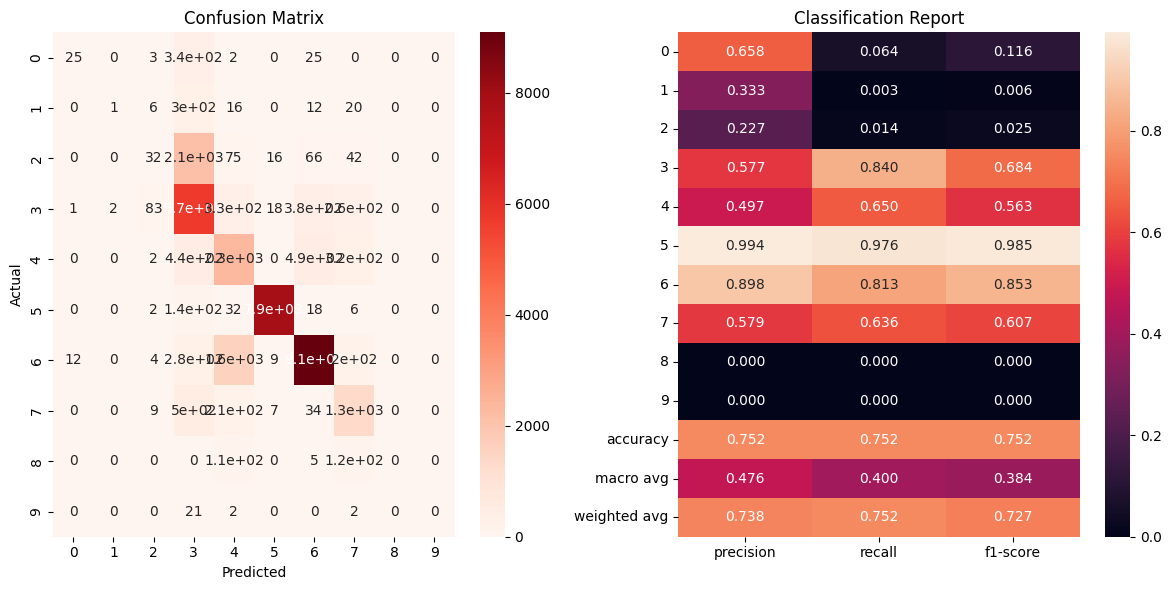

Accuracy: 0.7520031937038409


Accuracy Score,▁
f1-score_avg,▁
precision_avg,▁
recall_avg,▁
Accuracy Score,0.752
f1-score_avg,0.7275
precision_avg,0.73761
recall_avg,0.752


Train operation time: =  2.182253122329712 seconds

Model: DecisionTreeClassifier


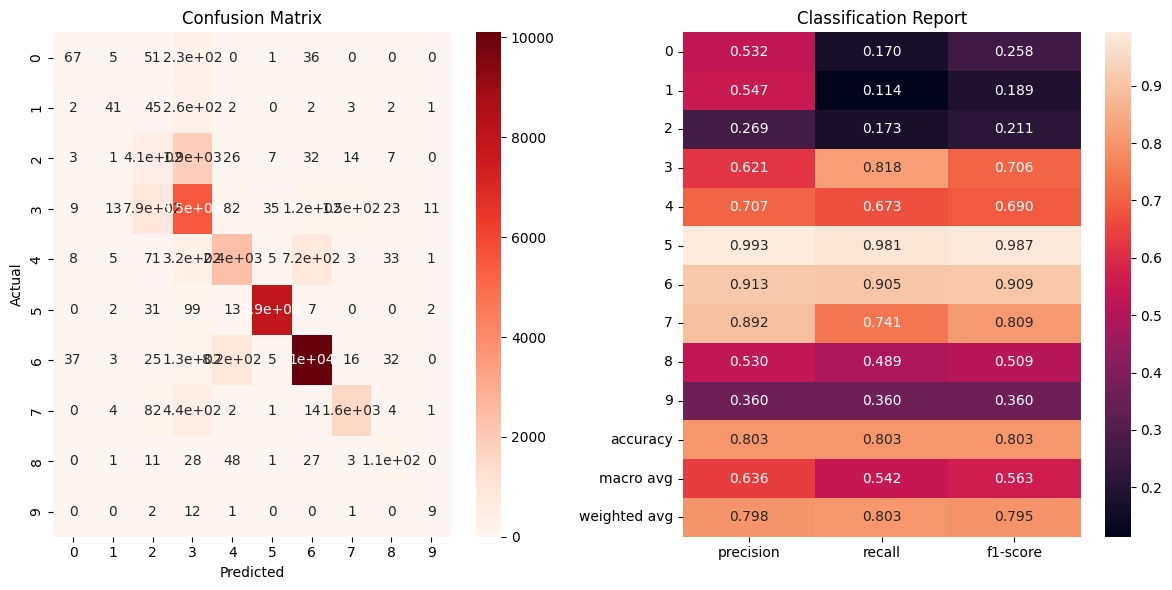

Accuracy: 0.8031594855855599


Accuracy Score,▁
f1-score_avg,▁
precision_avg,▁
recall_avg,▁
Accuracy Score,0.80316
f1-score_avg,0.79451
precision_avg,0.79846
recall_avg,0.80316


Train operation time: =  16.861366033554077 seconds

Model: RandomForestClassifier


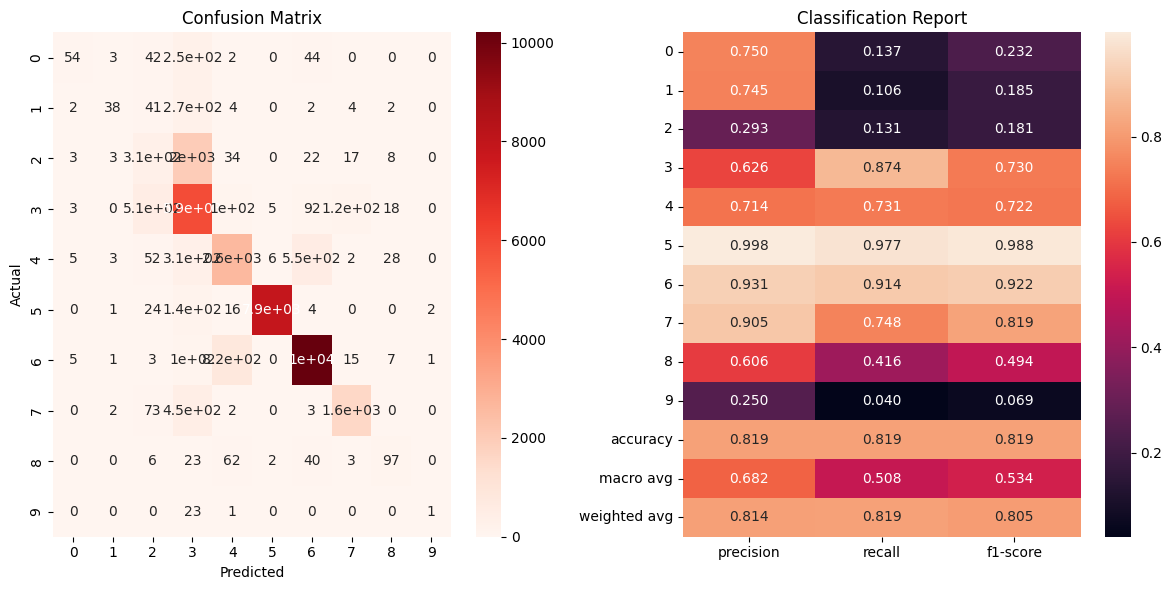

Accuracy: 0.8185291853203684


Accuracy Score,▁
f1-score_avg,▁
precision_avg,▁
recall_avg,▁
Accuracy Score,0.81853
f1-score_avg,0.80484
precision_avg,0.81427
recall_avg,0.81853


Train operation time: =  499.4500820636749 seconds

Model: GradientBoostingClassifier


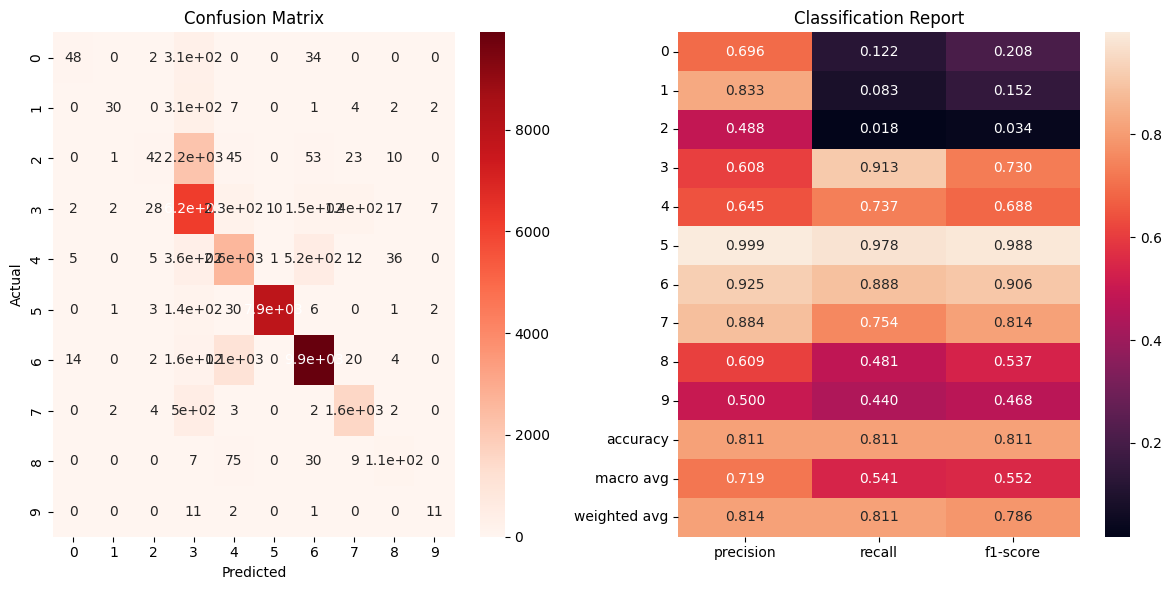

Accuracy: 0.8112863212523882


Accuracy Score,▁
f1-score_avg,▁
precision_avg,▁
recall_avg,▁
Accuracy Score,0.81129
f1-score_avg,0.78585
precision_avg,0.81428
recall_avg,0.81129


Train operation time: =  0.15211987495422363 seconds

Model: KNeighborsClassifier


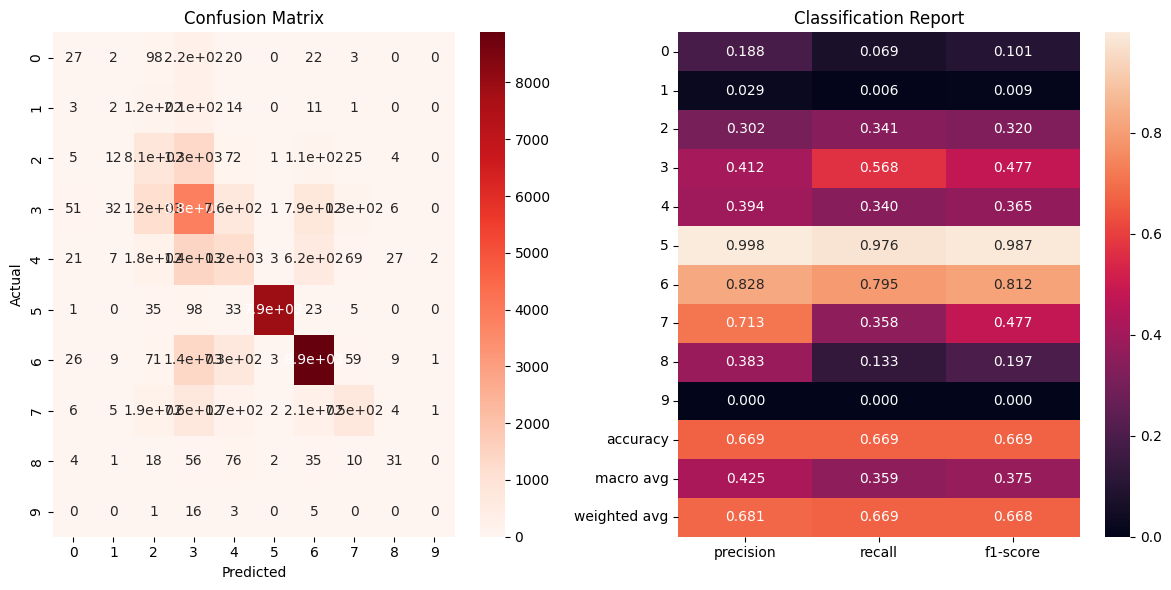

Accuracy: 0.6685391656448716


Accuracy Score,▁
f1-score_avg,▁
precision_avg,▁
recall_avg,▁
Accuracy Score,0.66854
f1-score_avg,0.66787
precision_avg,0.68142
recall_avg,0.66854


In [ ]:
# Loop through models and evaluate each one
project_name = "baseline-" + project_name
for model_name, model in models.items():
    wandb.init(project=project_name, name=model_name)
    
    # For SVM and Logistic Regression, use scaled data
    if model_name in ["Logistic Regression", "Support Vector Machine (SVM)"]:
        evaluate_model(model, X_train_scaled_df, y_train_df, X_test_scaled_df, y_test_df)
    else:
        evaluate_model(model, X_train_df, y_train_df, X_test_df, y_test_df)
        
    wandb.finish()

In [ ]:
wandb.finish()